This script performs dimensionality reduction using PCA to analyze comorbidity patterns.

Key steps:
1. **Create a pivot table**:
   - Transform diagnosis data into a structured format where rows represent patients and columns represent diagnoses.
   - Convert categorical data into a binary presence/absence matrix.
   - **Input:** `'Data/ad_demographics.csv'`, `'Data/ad_diagnosis.csv'`

2. **Perform PCA (Principal Component Analysis)**:
   - Compute the cumulative explained variance ratio to determine the number of principal components.
   - Select 1000 principal components for dimensionality reduction.
   - Transform the dataset using PCA.

3. **Save results for further analysis**:
   - Store the trained PCA model as a `.joblib` file.
   - Save the transformed data as a `.npy` file.
   - Save the pivoted diagnosis data as a `.pkl` file.
   - **Output:** `'Data/pca_model_n1000_rdm42.joblib'`, `'Data/pca_transformed_n1000_rdm42.npy'`, `'Data/alzdiag_pivot_rdm42.pkl'`


In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from sklearn.decomposition import PCA
import joblib

# 1. Making analysis datasets

## Load Datasets

In [2]:
alzcohort = pd.read_csv('Data/ad_demographics.csv')
alzdiag = pd.read_csv('Data/ad_diagnosis.csv')

## Change clounmns'name

In [3]:
alzcohort = alzcohort.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status','Value':'ICD10'})
alzdiag = alzdiag.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status','Value':'ICD10'})

In [4]:
alzdiag['PatientID'].nunique()

8804

## Exclude the record with NaN for ICD10

In [5]:
alzdiag = alzdiag[alzdiag['ICD10'].notna()]


In [6]:
alzdiag['PatientID'].nunique()

8804

## Make a pivot table

In [7]:
n = 'DiagnosisName'
alzdiag_pivot = pd.pivot_table(alzdiag[[n, 'PatientID']].drop_duplicates(), 
         values = [n], index = 'PatientID', columns = [n],
         aggfunc = lambda x: 1 if len(x)>0 else 0, fill_value = 0)
alzdiag_pivot['isAD'] = 1

## Delete columns containing "Alzheimer" in the disease name

In [8]:
colstodrop = alzdiag_pivot.columns[alzdiag_pivot.columns.str.contains('alzheimer', flags=re.IGNORECASE)]

In [9]:
alzdiag_pivot = alzdiag_pivot.drop(colstodrop , axis=1)

## Calculate total number of non-AD complications

In [10]:
alzdiag_pivot['#diagnosis'] = alzdiag_pivot.loc[:, ~alzdiag_pivot.columns.isin(['isAD'])].sum(axis=1)

<AxesSubplot:xlabel='#diagnosis', ylabel='Count'>

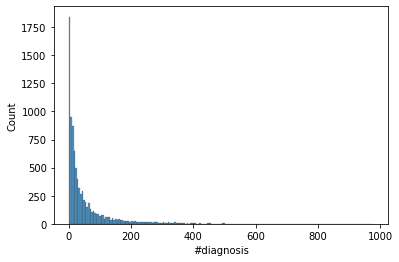

In [11]:
sns.histplot(alzdiag_pivot, x= alzdiag_pivot['#diagnosis'])

In [12]:
alzdiag_pivot['#diagnosis'].describe()

count    8804.000000
mean       50.902204
std        77.387373
min         0.000000
25%         7.000000
50%        21.000000
75%        60.000000
max       978.000000
Name: #diagnosis, dtype: float64

## Filter case who have at least one diagnosis name in addition to AD

In [13]:
alzdiag_pivot = alzdiag_pivot[alzdiag_pivot['#diagnosis'] >= 1]

## Join background table to alzdiag_pivot

In [14]:
demographic_cols = ['PatientID', 'Age', 'Sex', 'Race', 'Death_Status']

In [15]:
alzdiag_pivot = alzdiag_pivot.merge((alzcohort[demographic_cols]).set_index('PatientID'),
                how = 'left', left_index = True, right_index = True)
alzdiag_pivot = alzdiag_pivot.fillna(0)

# 2. Dimentional Reduction

In [16]:
demographic_cols = ['Age', 'Sex', 'Race', 'Death_Status','#diagnosis']

In [17]:
z = alzdiag_pivot[demographic_cols]
X = alzdiag_pivot.drop('isAD', axis=1).drop(demographic_cols, axis=1).astype('int32')

## PCA

In [18]:
pca = PCA(n_components= 2000, random_state=42)

In [19]:
mapper = pca.fit(X)

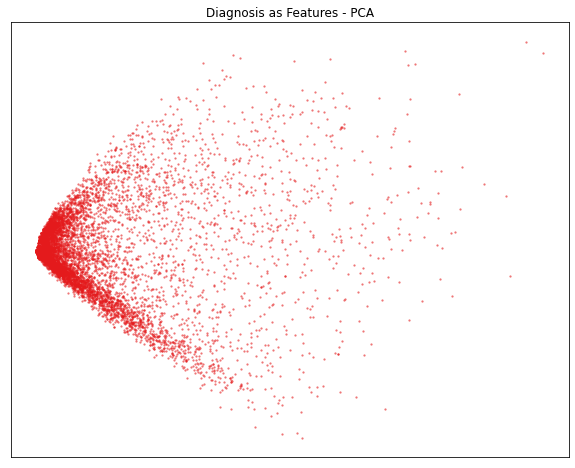

In [20]:
X_embedded = mapper.transform(X)

with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    sns.scatterplot(x= X_embedded[reordered_indices,0], y= X_embedded[reordered_indices,1],
    s= 5, linewidth= .0, alpha= .6)
    ax= plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white');
    plt.title('Diagnosis as Features - PCA')

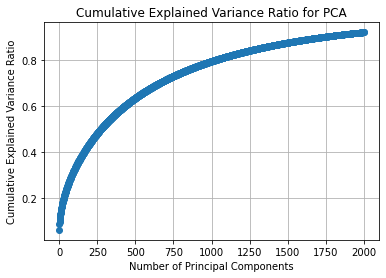

In [21]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.grid(True)
plt.show()

## 1000 PCA components are included in the analysis dataset

## PCA(n=1000)

In [22]:
pca = PCA(n_components=1000, random_state=42)
data_pca = pca.fit_transform(X)

In [23]:
# Save the model
joblib.dump(pca, 'Data/pca_model_n1000_rdm42.joblib')

# Save the transformed data
np.save('Data/pca_transformed_n1000_rdm42.npy', data_pca)


In [24]:
# Save as Pickle file
alzdiag_pivot.to_pickle('Data/alzdiag_pivot_rdm42.pkl')